In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
TRAIN = r"C:\Users\lokes\metadata_train.csv"
TEST = r"C:\Users\lokes\metadata_test.csv"
TRAIN_OUTPUT_PATH = r"C:\Users\lokes\processed_train.csv"
TEST_OUTPUT_PATH  = r"C:\Users\lokes\processed_test.csv"

In [3]:
train_df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)

print(train_df.shape, test_df.shape)

(16209, 22) (5404, 21)


In [4]:
train_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,img_path
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240,C:\Users\lokes\Downloads\data\images\911700017...
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605,C:\Users\lokes\Downloads\data\images\670039021...
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455,C:\Users\lokes\Downloads\data\images\721266054...
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750,C:\Users\lokes\Downloads\data\images\856278020...
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071,C:\Users\lokes\Downloads\data\images\776040035...


In [5]:
def basic_cleaning(df):
    df = df.copy()

    df["date"] = pd.to_datetime(df["date"], format="%Y%m%dT%H%M%S")
    df = df.drop_duplicates(subset=["id"])

    return df

In [6]:
train_df = basic_cleaning(train_df)
test_df = basic_cleaning(test_df)

print(train_df.shape, test_df.shape)

(16110, 22) (5396, 21)


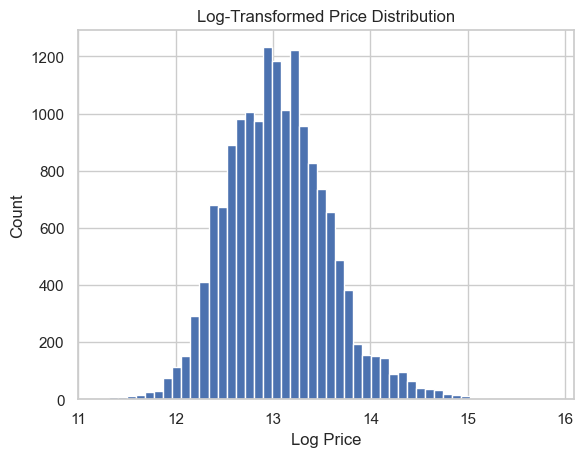

In [7]:
train_df["log_price"] = np.log1p(train_df["price"])

plt.figure()
plt.hist(train_df["log_price"], bins=50)
plt.xlabel("Log Price")
plt.ylabel("Count")
plt.title("Log-Transformed Price Distribution")
plt.show()

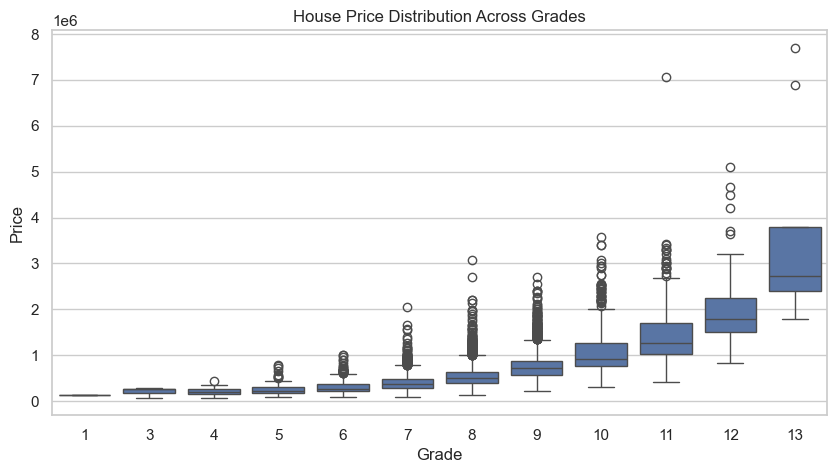

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=train_df,
    x="grade",
    y="price"
)
plt.title("House Price Distribution Across Grades")
plt.xlabel("Grade")
plt.ylabel("Price")
plt.show()


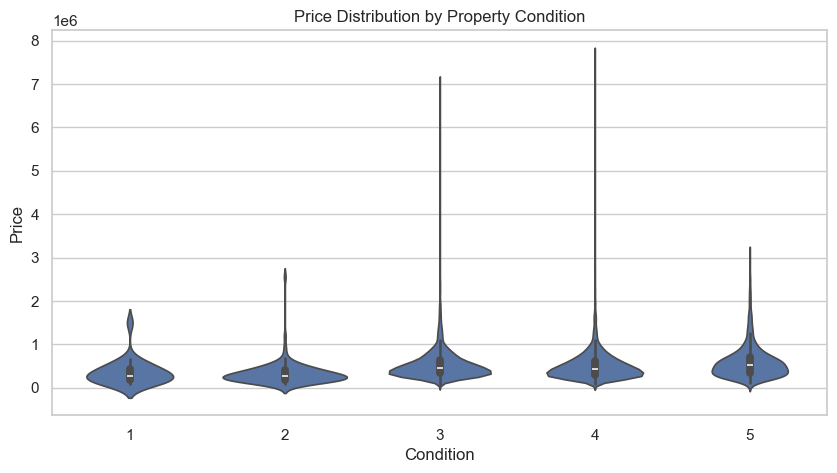

In [9]:
plt.figure(figsize=(10,5))
sns.violinplot(
    data=train_df,
    x="condition",
    y="price"
)
plt.title("Price Distribution by Property Condition")
plt.xlabel("Condition")
plt.ylabel("Price")
plt.show()


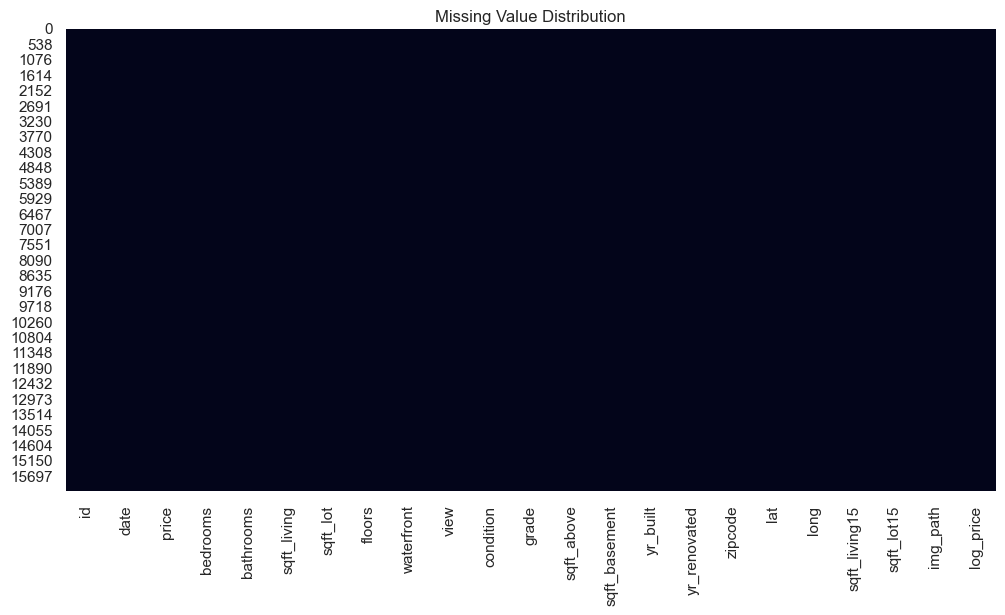

In [10]:
plt.figure(figsize=(12,6))
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Missing Value Distribution")
plt.show()


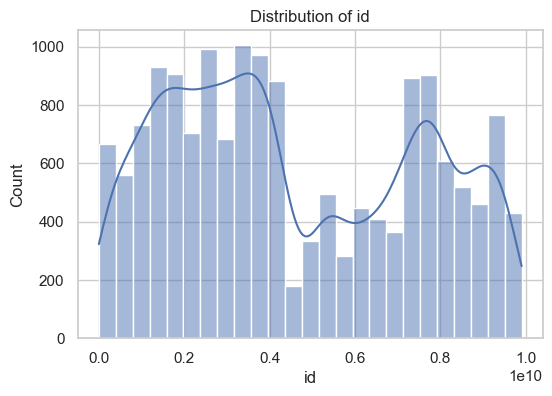

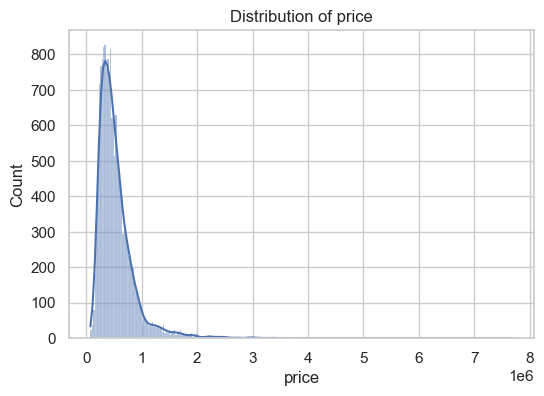

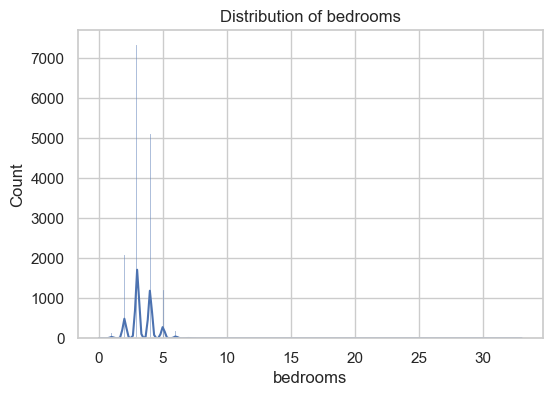

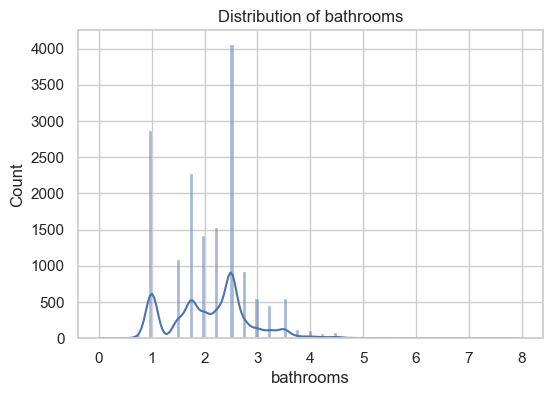

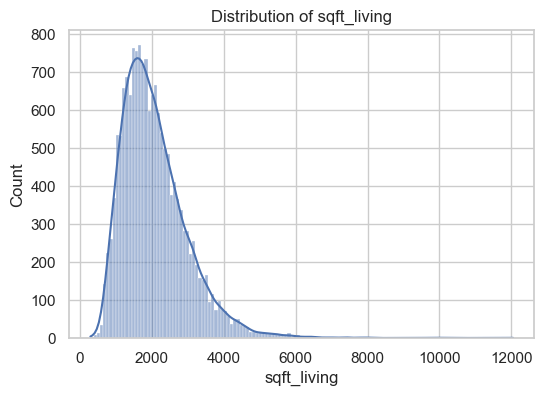

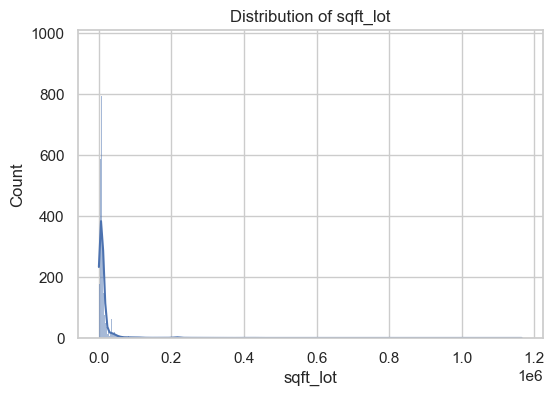

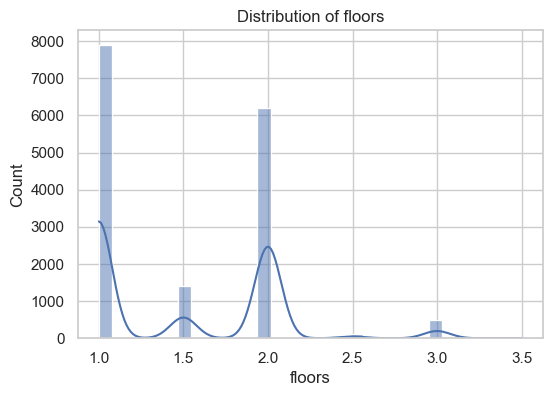

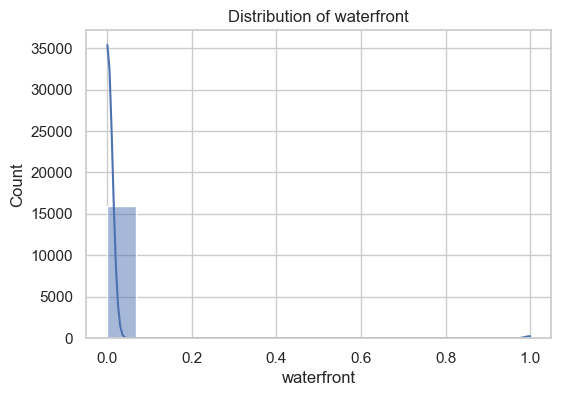

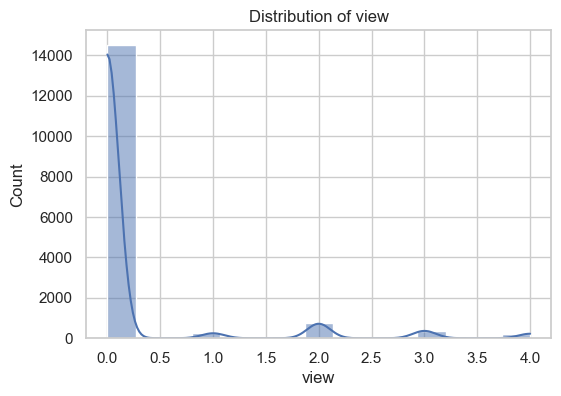

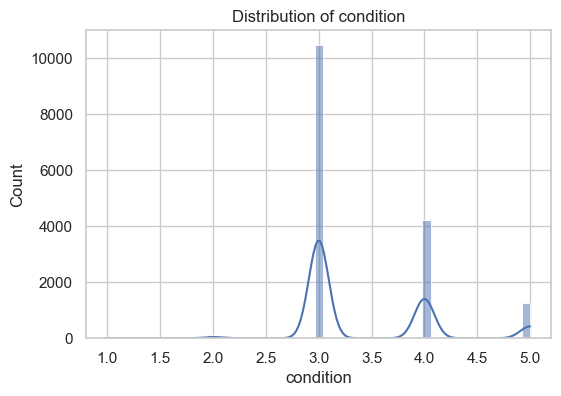

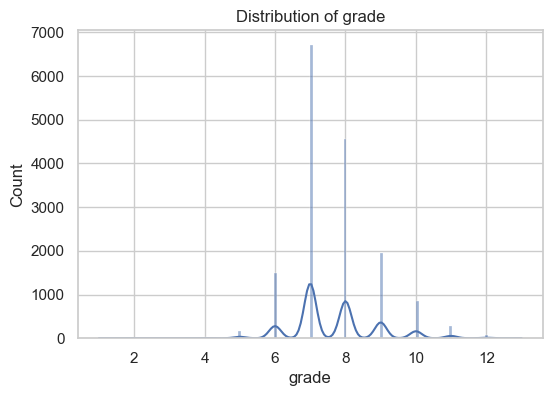

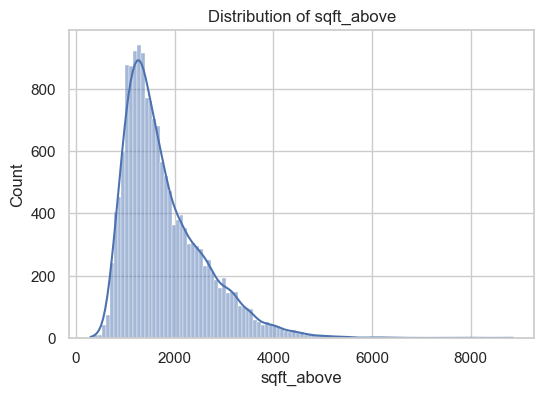

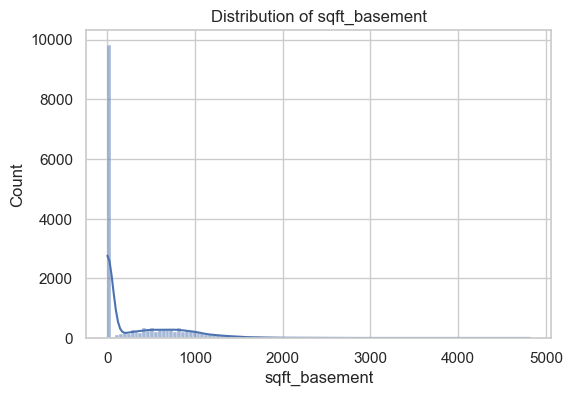

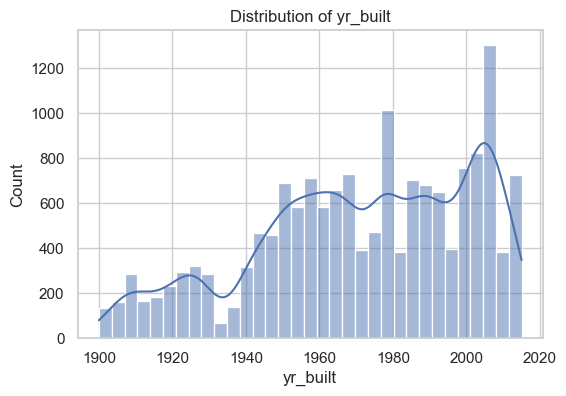

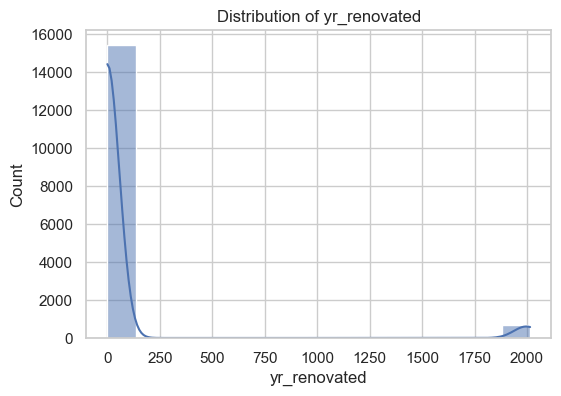

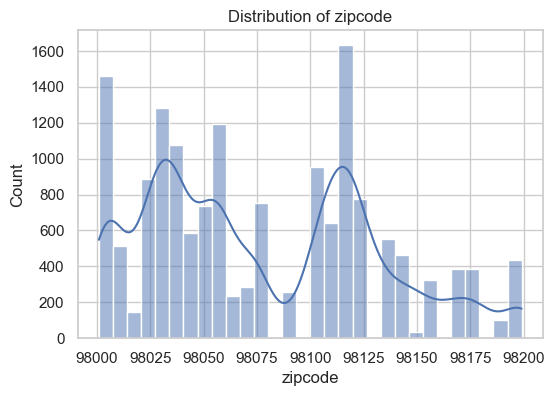

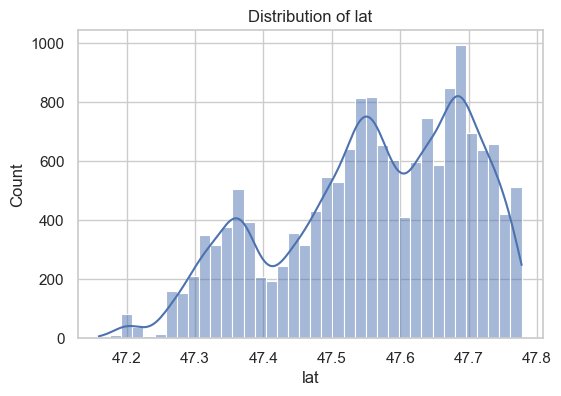

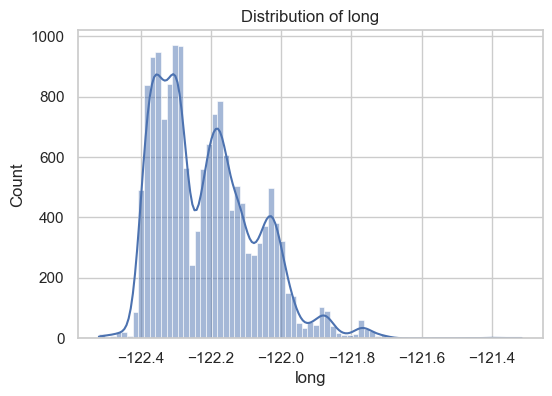

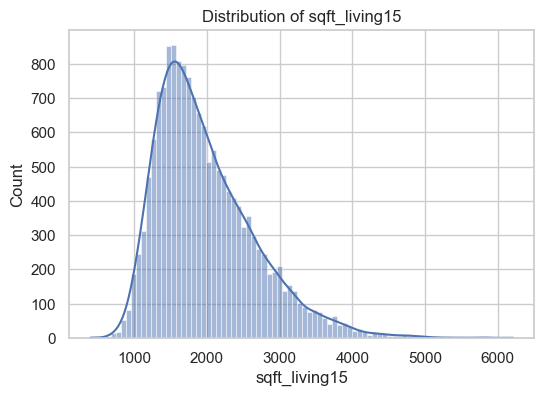

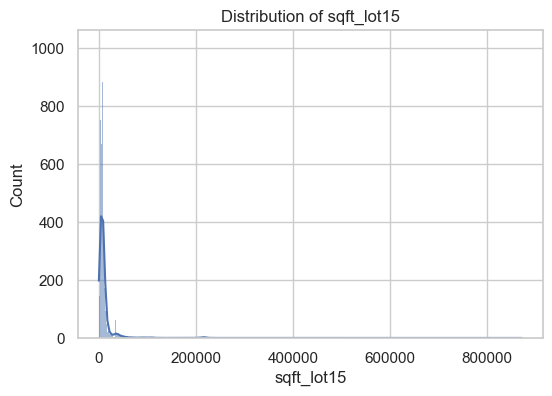

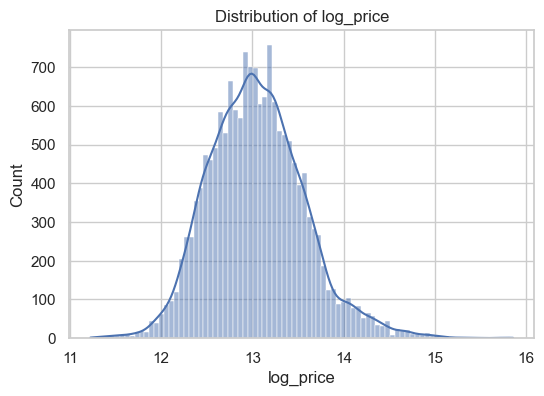

In [11]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


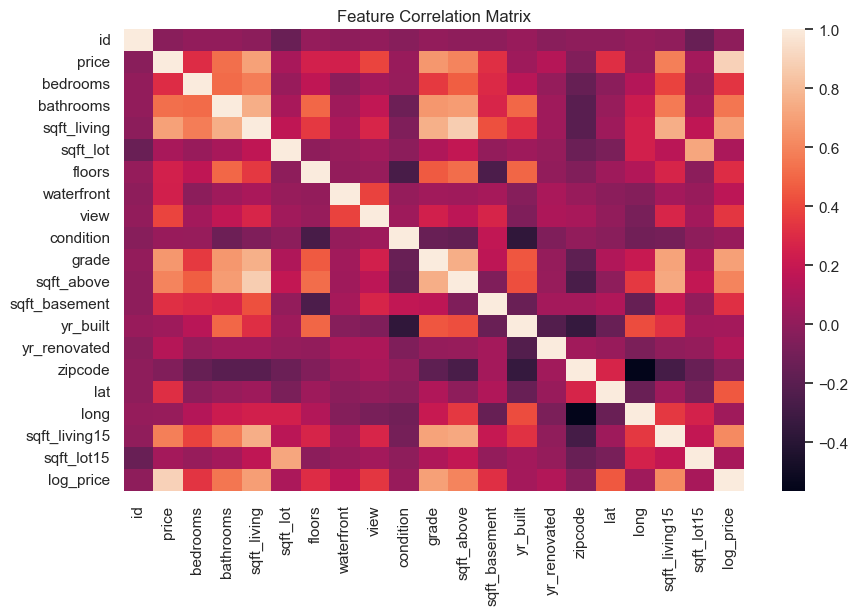

In [12]:
plt.figure(figsize=(10,6))
corr_matrix = train_df[numeric_cols].corr()

sns.heatmap(corr_matrix,   fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


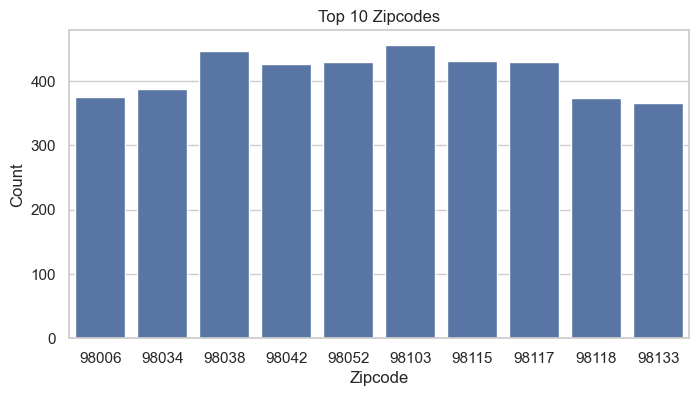

In [13]:
if "zipcode" in train_df.columns:
    top_zipcodes = train_df["zipcode"].value_counts().head(10)

    plt.figure(figsize=(8,4))
    sns.barplot(x=top_zipcodes.index, y=top_zipcodes.values)
    plt.title("Top 10 Zipcodes")
    plt.xlabel("Zipcode")
    plt.ylabel("Count")
    plt.show()


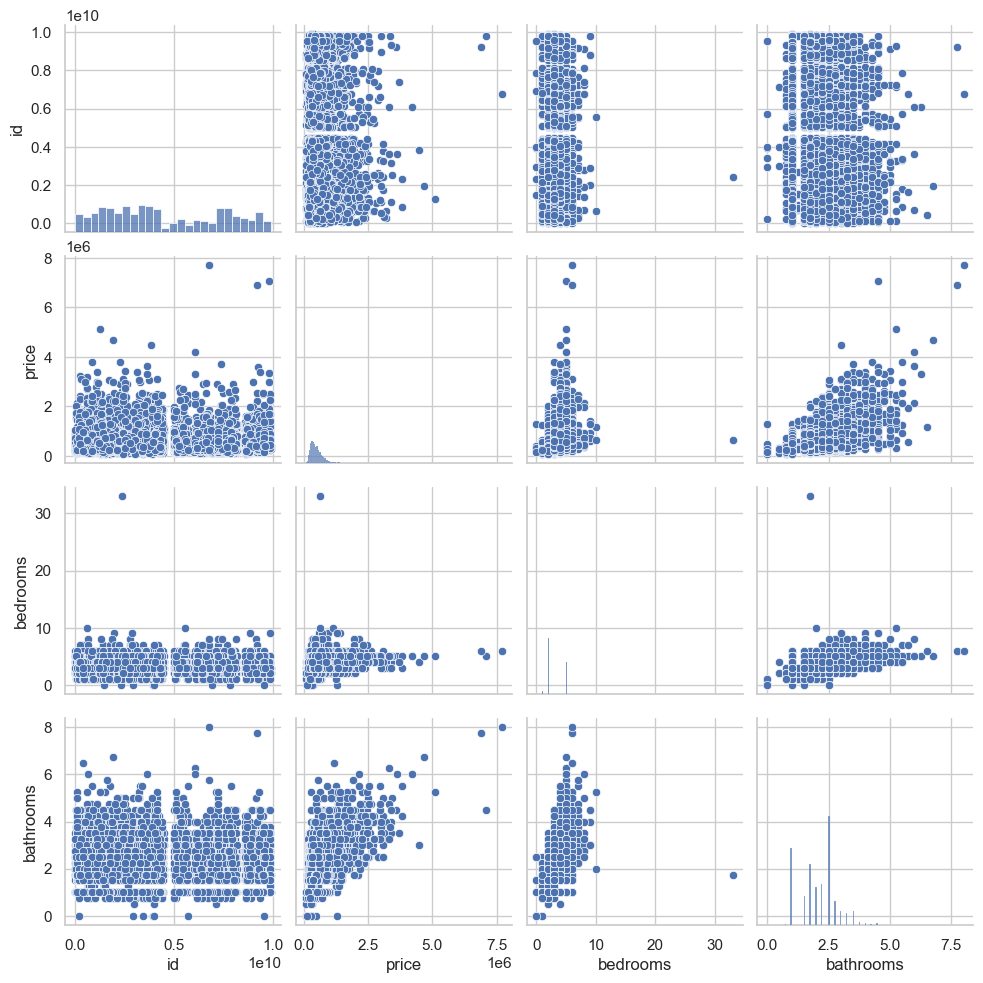

In [14]:
sns.pairplot(train_df[numeric_cols[:4]])
plt.show()


In [15]:
corr = train_df.corr(numeric_only=True)["price"].sort_values(ascending=False)
corr

price            1.000000
log_price        0.893409
sqft_living      0.700803
grade            0.663958
sqft_above       0.602189
sqft_living15    0.580816
bathrooms        0.525553
view             0.390283
sqft_basement    0.320730
lat              0.309853
bedrooms         0.305568
floors           0.250594
waterfront       0.245810
yr_renovated     0.133868
sqft_lot         0.087354
sqft_lot15       0.075413
yr_built         0.046811
condition        0.029359
long             0.023493
id              -0.021890
zipcode         -0.052756
Name: price, dtype: float64

In [16]:
def feature_engineering(df):
    df = df.copy()

    df["house_age"] = df["date"].dt.year - df["yr_built"]

    df["renovation_age"] = np.where(
        df["yr_renovated"] == 0,
        df["house_age"],
        df["date"].dt.year - df["yr_renovated"]
    )

    df["total_rooms"] = df["bedrooms"] + df["bathrooms"]

    df["living_lot_ratio"] = df["sqft_living"] / df["sqft_lot"]
    df["living_lot_ratio"] = df["living_lot_ratio"].replace([np.inf, -np.inf], np.nan)
    df["living_lot_ratio"] = df["living_lot_ratio"].fillna(0)

    df["has_basement"] = (df["sqft_basement"] > 0).astype(int)

    return df

In [17]:
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

In [18]:
train_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,img_path,log_price,house_age,renovation_age,total_rooms,living_lot_ratio,has_basement
0,9117000170,2015-05-05,268643,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240,C:\Users\lokes\Downloads\data\images\911700017...,12.501142,54,54,6.25,0.195887,0
1,6700390210,2014-07-08,245000,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605,C:\Users\lokes\Downloads\data\images\670039021...,12.409018,22,22,5.50,0.573888,0
2,7212660540,2015-01-15,200000,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455,C:\Users\lokes\Downloads\data\images\721266054...,12.206078,21,21,6.50,0.199120,0
3,8562780200,2015-04-27,352499,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750,C:\Users\lokes\Downloads\data\images\856278020...,12.772806,6,6,4.25,1.758865,1
4,7760400350,2014-12-05,232000,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071,C:\Users\lokes\Downloads\data\images\776040035...,12.354497,20,20,5.00,0.095837,0


In [19]:
num_cols = [
    "sqft_living",
    "sqft_lot",
    "sqft_basement",
    "living_lot_ratio"
]

clip_bounds = {}

for col in num_cols:
    low, high = train_df[col].quantile([0.01, 0.99])
    clip_bounds[col] = (low, high)

    train_df[col] = train_df[col].clip(low, high)

In [20]:
DROP_COLS = ["id", "date", "price", "lat", "long", "sqft_living15", "sqft_lot15"]

train_model = train_df.drop(columns=DROP_COLS)
test_model = test_df.drop(columns=[c for c in DROP_COLS if c not in ["price", "id"]])

In [21]:
y_train = train_model["log_price"]

In [22]:
test_ids = test_model["id"]
test_model = test_model.drop(columns=["id"])

CATEGORICAL = ["zipcode", "condition", "grade", "view", "waterfront"]

train_model = pd.get_dummies(
    train_model,
    columns=CATEGORICAL,
    drop_first=False,
    dtype=np.float32
)

test_model = pd.get_dummies(
    test_model,
    columns=CATEGORICAL,
    drop_first=False,
    dtype=np.float32
)

train_model, test_model = train_model.align(test_model, join="left", axis=1)
test_model = test_model.fillna(0)

test_model["id"] = test_ids.values
test_model.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,img_path,log_price,house_age,renovation_age,total_rooms,living_lot_ratio,has_basement,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,condition_1,condition_2,condition_3,condition_4,condition_5,grade_1,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_0,view_1,view_2,view_3,view_4,waterfront_0,waterfront_1,id
0,4,2.25,2070,8893,2.0,2070,0,1986,0,C:\Users\lokes\Downloads\data\images\259182031...,0.0,28,28,6.25,0.232767,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2591820310
1,5,3.00,2900,6730,1.0,1830,1070,1977,0,C:\Users\lokes\Downloads\data\images\797420082...,0.0,37,37,8.00,0.430906,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7974200820
2,4,2.50,3770,10893,2.0,3770,0,1997,0,C:\Users\lokes\Downloads\data\images\770145011...,0.0,17,17,6.50,0.346094,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7701450110
3,3,3.50,4560,14608,2.0,4560,0,1990,0,C:\Users\lokes\Downloads\data\images\952230001...,0.0,25,25,6.50,0.312158,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9522300010
4,3,2.50,2550,5376,2.0,2550,0,2004,0,C:\Users\lokes\Downloads\data\images\951086114...,0.0,10,10,5.50,0.474330,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9510861140


In [23]:
test_model.shape

(5396, 111)

In [24]:
def clean_invalid_numbers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    return df

y_train=clean_invalid_numbers(y_train)
train_model = clean_invalid_numbers(train_model)
train_model["log_price"]=y_train
test_model = clean_invalid_numbers(test_model)

In [28]:
train_model.to_csv(TRAIN_OUTPUT_PATH, index=False)
test_model .to_csv(TEST_OUTPUT_PATH, index=False)

print("✅ Preprocessing complete. Files saved successfully.")


✅ Preprocessing complete. Files saved successfully.
